# Thermal emission noise of HZG NIT ch4
2022-03-30 H. Akitaya (PERC, CIT)

## Instrumental parameters.

In [1]:
import sys

In [2]:
from hzgdev.phot import simimg

In [3]:
params = simimg.HZGParams()

In [4]:
# Get attributions.
attars = [x for x in dir(params) if not x.startswith('_')]

In [5]:
attars = [x for x in dir(params) if not x.startswith('_')]
# Show attributions.
for attar in attars:
    print('params.{} = {}'.format(attar, getattr(params, attar)))

params.band_wls = {'o': [<Quantity 0.5 um>, <Quantity 0.9 um>], 'j': [<Quantity 0.9 um>, <Quantity 1.5 um>], 'h': [<Quantity 1.5 um>, <Quantity 2. um>], 'k': [<Quantity 2. um>, <Quantity 2.5 um>]}
params.bands = ['o', 'j', 'h', 'k']
params.d_tel = 0.3 m
params.darkrate = 0.3 1 / s
params.eff_tel = 0.63
params.elat = 45.0
params.fwhm = 1.5
params.pix_fov = 4.0 arcsec2
params.ron = 18.0
params.show = <bound method HZGParams.show of <hzgdev.phot.simimg.HZGParams object at 0x7fc2594ba3e0>>
params.t_exp = 120.0 s


In [6]:
n_pix = 9.0  # Number of pixels in a photometry aperture.
n_frames = 5.0  # Number of frames (revised).
# zd_elat = params.elat  # Ecliptic latitude for zodiacal light. (-> not used now.)

# Define possible band properties for ch4.

In [7]:
import astropy.units as u

In [8]:
params.bands = ['k0', 'k1', 'k2', 'k3']
params.band_wls = {
    'k0': [2.0*u.um, 2.5*u.um],  # Original.
    'k1': [1.7*u.um, 2.1*u.um],  # Case 1.
    'k2': [1.7*u.um, 2.0*u.um],  # Case 2.
    'k3': [1.6*u.um, 2.0*u.um],  # Case 3.
}

# Zeromag calculation for newly defined bands.

In [9]:
c_zeromag = simimg.get_zeromag(params.band_wls)

In [10]:
c_zeromag

{'k0': <Quantity 1222723.6463178 1 / (cm2 s)>,
 'k1': <Quantity 1157876.28182479 1 / (cm2 s)>,
 'k2': <Quantity 890528.70630069 1 / (cm2 s)>,
 'k3': <Quantity 1222723.6463178 1 / (cm2 s)>}

# Zodiacal light photon flux density for newly defined bands.

In [11]:
from zodiacal.zodiacallight import ZodiacalLight

In [12]:
zd = ZodiacalLight()

In [13]:
zdpfd = {}  # ZD photon flux density dict.

In [14]:
for band in params.bands:
    zlpflux = zd.get_zl_photonflux_wlinteg(params.band_wls[band][0].value,
                                           params.band_wls[band][1].value,
                                           params.elat, unit=True)
    zdpfd[band] = zlpflux

In [15]:
print(zdpfd)

{'k0': <Quantity 2.71368979e+11 1 / (m2 s sr)>, 'k1': <Quantity 3.3704275e+11 1 / (m2 s sr)>, 'k2': <Quantity 2.68304127e+11 1 / (m2 s sr)>, 'k3': <Quantity 3.90516287e+11 1 / (m2 s sr)>}


# Dark

In [16]:
params.darkrate  # To be multiplied by exposure time and total pixel numbers.

<Quantity 0.3 1 / s>

# Black body radiation from the instrument.

In [17]:
import numpy as np
from scipy import integrate

import astropy.constants as c
from astropy.modeling import models

## Calculate photon flux density for an integrated band.

$$
I = \int^{\lambda_2}_{\lambda_1} f_\mathrm{planck}(\lambda)/(hc/\lambda) d\lambda\ \mathrm{[photons\ cm^{-2} s^{-1} str^{-1}]}
$$

In [18]:
def bb_photon_flux_density(temperature: float, wl1: float, wl2: float, unit=True):
    """
    Calculate photon flux density of black body integrated between wl1 and wl2.
    :param temperature: Black body temperature (float) [K]
    :param wl1: Min. wavelength (float) [um]
    :param wl2: Max. wavelength (float) [um]
    :param unit: Output with unit or not.
    """
    # Define blackbody model as wavelength function
    bb_wl = models.BlackBody(temperature=temperature*u.K, scale=1.0*u.erg/u.cm**2/u.AA/u.s/u.sr)
    # Integration between wl1 and wl2.
    bb_photon_flux_density = integrate.quad(lambda x:
                                            ((bb_wl(x*u.um)/(c.h*c.c/(x*u.um))).to(1.0/u.um/u.cm**2/u.s/u.sr)).value,
                                            wl1, wl2)
    # Return wavelength-integrated photon flux density with a unit (as Quantity).
    if unit is False:
        return bb_photon_flux_density[0]
    else:
        return bb_photon_flux_density[0] * (1.0 / u.cm ** 2 / u.s / u.sr)

## Blackbody photon flux density values for defined bands.

In [19]:
sys.stdout.write('# Black body photon flux density (photons/u.cm**2/u.s/u.sr)\n')
sys.stdout.write('# {:>13s}'.format('Temp. [K]'))
for band in params.bands:
    sys.stdout.write('{:>15s}'.format(band))
sys.stdout.write('\n')

for temperature in np.linspace(200,300, 11):
    sys.stdout.write('{:>15.1f}'.format(temperature))
    for band in params.bands:
        #bbfd = bb_photon_flux_density(temperature,
        #                              params.band_wls[band][0].value,
        #                              params.band_wls[band][1].value,
        #                              unit=False)
        sys.stdout.write('{:>15.7e}'.format(bb_photon_flux_density(temperature,
                                                                  params.band_wls[band][0].value,
                                                                  params.band_wls[band][1].value,
                                                                  unit=False
                                                                  )))
    sys.stdout.write('\n')

# Black body photon flux density (photons/u.cm**2/u.s/u.sr)
#     Temp. [K]             k0             k1             k2             k3
          200.0  4.5457858e+07  2.6554260e+05  5.2552909e+04  5.2669400e+04
          210.0  1.8845025e+08  1.4287043e+06  3.0654569e+05  3.0745469e+05
          220.0  6.8808998e+08  6.6119554e+06  1.5265264e+06  1.5324162e+06
          230.0  2.2495349e+09  2.6839874e+07  6.6241011e+06  6.6565642e+06
          240.0  6.6756068e+09  9.7132920e+07  2.5479195e+07  2.5634501e+07
          250.0  1.8190357e+10  3.1771012e+08  8.8128977e+07  8.8784878e+07
          260.0  4.5959885e+10  9.5017860e+08  2.7746443e+08  2.7994510e+08
          270.0  1.0857090e+11  2.6240765e+09  8.0343900e+08  8.1194423e+08
          280.0  2.4151308e+11  6.7487199e+09  2.1588192e+09  2.1855330e+09
          290.0  5.0901578e+11  1.6282123e+10  5.4241008e+09  5.5016618e+09
          300.0  1.0218837e+12  3.7084713e+10  1.2828492e+10  1.3038294e+10


# Readout noise.

In [20]:
rno_squared = params.ron**2 * n_pix * n_frames

In [21]:
rno_squared

14580.0

# Calculation of emerged signals for each element.

In [22]:
# Sample condition.
band = 'k0'
temperature = 270.0
mag = 20.0

In [23]:
# Emissivity of the M1.
emissivity_m1 = 0.1

## Signal.

In [24]:
# Stellar object.
ph_obj = (c_zeromag[band] * 10**(-mag/2.5) * params.t_exp * n_frames *
          (params.d_tel/2.0)**2.0*np.pi * params.eff_tel).decompose().value

In [25]:
ph_obj

3267.0253307584694

In [26]:
# Dark.
ph_dk = (params.darkrate * params.t_exp * n_frames * n_pix).decompose().value

In [27]:
ph_dk

1620.0

In [28]:
# Zodiacal light.
ph_zd = (zdpfd[band] * params.t_exp * n_frames * (params.d_tel/2.0)**2.0*np.pi * params.eff_tel *
         params.pix_fov * n_pix).decompose().value

In [29]:
ph_zd

6135.311622347735

In [30]:
# Thermal emission of instruments.
ph_th = (bb_photon_flux_density(temperature,
                               params.band_wls[band][0].value, params.band_wls[band][1].value) * \
    emissivity_m1 * \
    params.t_exp * n_frames * (params.d_tel/2.0)**2.0*np.pi * params.eff_tel * params.pix_fov * n_pix).decompose().value

In [31]:
ph_th

2454651.6823084108

In [32]:
sig_total = ph_obj
count_total = ph_obj + ph_dk + ph_zd + ph_th

In [33]:
print(sig_total, count_total)

3267.0253307584694 2465674.019261517


## Noise.

In [34]:
noise_total = np.sqrt(count_total + params.ron**2 * n_pix * n_frames)

In [35]:
noise_total

1574.8822239334334

In [36]:
sn = sig_total /noise_total

In [37]:
sn

2.0744569219904783

# General function for calculate signals and noises.

In [38]:
def get_signals_and_noises(params: simimg.HZGParams, temperature, mag, band, n_pix, n_frames, emissivity_m1):
    # Stellar object.
    ph_obj = (c_zeromag[band] * 10 ** (-mag / 2.5) * params.t_exp * n_frames *
               (params.d_tel / 2.0) ** 2.0 * np.pi * params.eff_tel).decompose().value
    # Dark.
    ph_dk = (params.darkrate * params.t_exp * n_frames * n_pix).decompose().value
    # Zodiacal light.
    ph_zd = (zdpfd[band] * params.t_exp * n_frames * (params.d_tel / 2.0) ** 2.0 * np.pi * params.eff_tel *
              params.pix_fov * n_pix).decompose().value
    # Thermal emission of instruments.
    ph_th = (bb_photon_flux_density(temperature,
                                     params.band_wls[band][0].value, params.band_wls[band][1].value) *
              emissivity_m1 *
              params.t_exp * n_frames * (params.d_tel / 2.0) ** 2.0 * np.pi *
              params.eff_tel * params.pix_fov * n_pix).decompose().value
    sig_total = ph_obj
    count_total = ph_obj + ph_dk + ph_zd + ph_th
    noise_ron_squared = params.ron ** 2 * n_pix * n_frames
    noise_total = np.sqrt(count_total + noise_ron_squared)
    sn_ratio = sig_total / noise_total
    return band, temperature, mag, sn_ratio, ph_obj, ph_dk, ph_zd, ph_th, noise_ron_squared, noise_total**2

In [39]:
## Some checks.

In [40]:
get_signals_and_noises(params, 230.0, 20.0, 'k0', 9, 5, 0.1)

('k0',
 230.0,
 20.0,
 11.814928927637654,
 3267.0253307584694,
 1620.0,
 6135.311622347735,
 50859.15652139757,
 14580.0,
 76461.49347450378)

calculation sample. (t=270, 'k1')

In [41]:
solution2 = get_signals_and_noises(params, 270.0, 20.0, 'k1', 9, 5, 0.1)

In [42]:
params.show()

Band names: ['k0', 'k1', 'k2', 'k3']
Band Wavelength Definitions: {'k0': [<Quantity 2. um>, <Quantity 2.5 um>], 'k1': [<Quantity 1.7 um>, <Quantity 2.1 um>], 'k2': [<Quantity 1.7 um>, <Quantity 2. um>], 'k3': [<Quantity 1.6 um>, <Quantity 2. um>]}
FOV per pixel: 4.0 arcsec2
Efficiency of instrument: 0.63
Diameter of telescope: 0.3 m
Exposure time per one frame 120.0 s
Ecliptic latitude (deg): 
FWHM of stellar image: 
Dark count rate: 
Readout noise (e-/pix) 18.0


0

In [43]:
solution2

('k1',
 270.0,
 20.0,
 10.534880205057437,
 3093.7580654450107,
 1620.0,
 7620.113050071549,
 59327.07135512055,
 14580.0,
 86240.94247063712)

In [44]:
print('Thermal Photons = {}'.format(solution2[7]))
print('RO noise**2 = {}'.format(solution2[8]))
print('(Thermal Photons)/(RO noise**2) = {:.2f}'.format(solution2[7]/solution2[8]))
print(' at band={}, T={} K, aperture = {} pixels, N. of frames = {}, M1 emissivity={}'.format(
    solution2[0], solution2[1], n_pix, n_frames, emissivity_m1))

Thermal Photons = 59327.07135512055
RO noise**2 = 14580.0
(Thermal Photons)/(RO noise**2) = 4.07
 at band=k1, T=270.0 K, aperture = 9.0 pixels, N. of frames = 5.0, M1 emissivity=0.1


In [45]:
band = 'k1'
mag = 20.0
sols = []
for temperature in np.linspace(200, 300, 11):
    sol = list(get_signals_and_noises(params, temperature, mag, band, n_pix, n_frames, emissivity_m1))
    sol.append(sol[7]/sol[8])
    sols.append(sol)

In [46]:
from astropy.table import Table

In [47]:
tb_sols = Table(rows=sols, names=('band', 'temperature', 'mag', 'sn', 'ph_obj', 'ph_dk', 'ph_zd',
                                  'ph_th', 'ron_sq', 'total_noise', 'ron_sq_over_ph_th'))

In [48]:
tb_sols.show_in_notebook()

In [49]:
import matplotlib.pyplot as plt

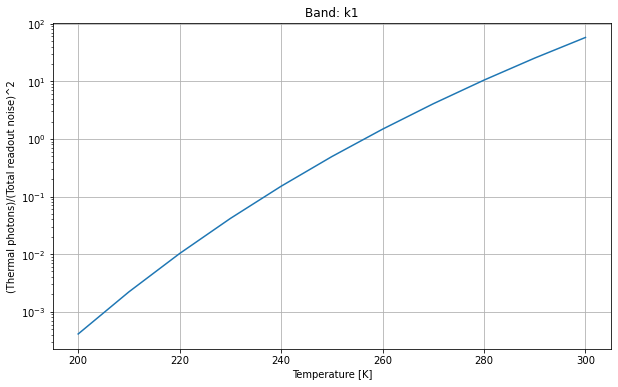

In [50]:
plt.figure(figsize=(10,6))
plt.title('Band: {}'.format(band))
plt.grid()
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('(Thermal photons)/(Total readout noise)^2')
plt.plot(tb_sols['temperature'], tb_sols['ron_sq_over_ph_th'])
plt.show()

In [51]:
plt.figure(figsize=(10,6))
plt.title('Error budgets for band: {}, mag: {}'.format(band, mag))
plt.grid()
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('Ratio of squared error')
plt.plot(tb_sols['temperature'], tb_sols['ron_sq']/tb_sols['total_noise'], label = 'RO noise')
plt.plot(tb_sols['temperature'], tb_sols['ph_th']/tb_sols['total_noise'], label = 'Thermal BG')
plt.plot(tb_sols['temperature'], tb_sols['ph_zd']/tb_sols['total_noise'], label = 'Zodiacal BG')
plt.plot(tb_sols['temperature'], tb_sols['ph_dk']/tb_sols['total_noise'], label = 'Dark noise')
plt.plot(tb_sols['temperature'], tb_sols['ph_obj']/tb_sols['total_noise'], label = 'Object shot noise')
plt.legend()
plt.show()

In [52]:
t1 = 270.0
emissivity_m1_1 = 0.1

In [53]:
emissivity_m1 = 0.1
mags = []
sns = {'k0': [], 'k1': [], 'k2': [], 'k3': []}
for mag in np.linspace(17.0, 22.0, 101):
    mags.append(mag)
    for band in params.bands:
        result = get_signals_and_noises(params, t1, mag, band, 9, 5, emissivity_m1_1)
        sns[band].append(result[3])

In [54]:
import matplotlib.pyplot as plt

In [55]:
plt.figure(figsize=(12,8))
plt.grid()
plt.xlim([18, 22])
plt.ylim([0,60])
plt.xlabel('mag')
plt.ylabel('SN ratio')
plt.title('Temperature={} K, M1 emissivity={:.2f}, Exp.={} s'.format(t1, emissivity_m1_1, params.t_exp))
plt.plot(mags, sns['k0'], label = '2.0-2.5 um')
plt.plot(mags, sns['k1'], label = '1.7-2.1 um')
plt.plot(mags, sns['k2'], label = '1.7-2.0 um')
plt.plot(mags, sns['k3'], label = '1.6-2.0 um')
plt.legend()
plt.plot([17.0, 22.0], [10, 10])
plt.show()

In [56]:
emissivity_m1_2 = 0.0
mags2 = []
sns2 = {'k0': [], 'k1': [], 'k2': [], 'k3': []}
for mag in np.linspace(17.0, 22.0, 101):
    mags2.append(mag)
    for band in params.bands:
        result = get_signals_and_noises(params, t1, mag, band, 9, 5, emissivity_m1_2)
        sns2[band].append(result[3])

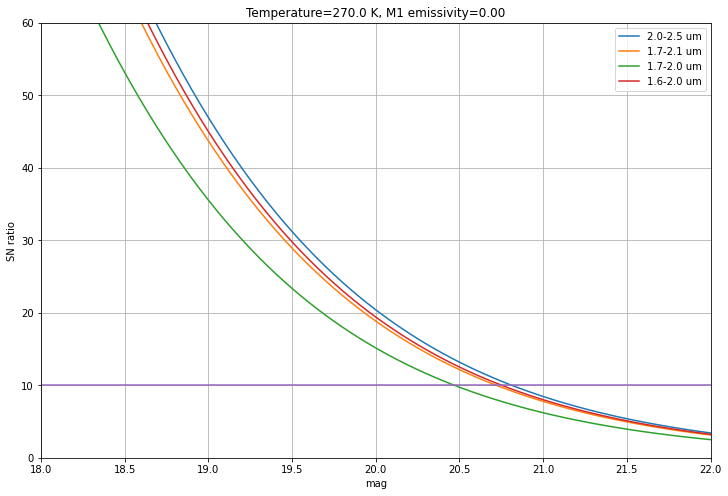

In [57]:
plt.figure(figsize=(12,8))
plt.grid()
plt.xlim([18, 22])
plt.ylim([0,60])
plt.xlabel('mag')
plt.ylabel('SN ratio')
plt.title('Temperature={} K, M1 emissivity={:.2f}'.format(t1, emissivity_m1_2))
plt.plot(mags2, sns2['k0'], label = '2.0-2.5 um')
plt.plot(mags2, sns2['k1'], label = '1.7-2.1 um')
plt.plot(mags2, sns2['k2'], label = '1.7-2.0 um')
plt.plot(mags2, sns2['k3'], label = '1.6-2.0 um')
plt.legend()
plt.plot([17.0, 22.0], [10, 10])
plt.show()

In [58]:
t3 = 200
emissivity_m1_3 = 0.1
mags3 = []
sns3 = {'k0': [], 'k1': [], 'k2': [], 'k3': []}
for mag in np.linspace(17.0, 22.0, 101):
    mags3.append(mag)
    for band in params.bands:
        result = get_signals_and_noises(params, t3, mag, band, 9, 5, emissivity_m1_3)
        sns3[band].append(result[3])

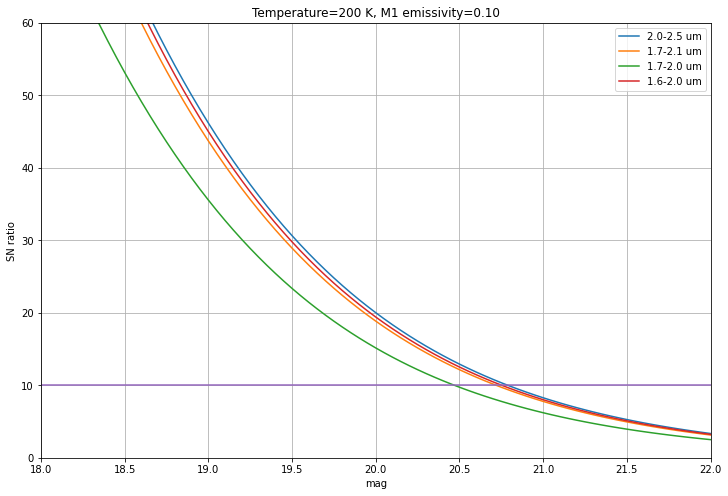

In [59]:
plt.figure(figsize=(12,8))
plt.grid()
plt.xlim([18, 22])
plt.ylim([0,60])
plt.xlabel('mag')
plt.ylabel('SN ratio')
plt.title('Temperature={} K, M1 emissivity={:.2f}'.format(t3, emissivity_m1_3))
plt.plot(mags3, sns3['k0'], label = '2.0-2.5 um')
plt.plot(mags3, sns3['k1'], label = '1.7-2.1 um')
plt.plot(mags3, sns3['k2'], label = '1.7-2.0 um')
plt.plot(mags3, sns3['k3'], label = '1.6-2.0 um')
plt.legend()
plt.plot([17.0, 22.0], [10, 10])
plt.show()

# Calculation for actual parameters.

In [60]:
from astropy.table import QTable
from scipy.optimize import fsolve
import sys

In [61]:
t1 = 200.0
t2 = 300.0
tn = 41
n_pix = 9  # number of pixels of a photometry aperture.
n_frames = 5 # number of frames.
emissivity_m1 = 0.1
tbls = {}
sn_criterion = 10
mag_solve_init = 20.0  # Initial magnitude for fsolve.
for band in ['k0', 'k1', 'k2', 'k3']:
    print(band)
    temps = []
    mags = []
    counter = 0
    for temperature in np.linspace(t1, t2, tn):
        def func(x, params, temperature, band, n_pix, n_frames, emissivity_m1, sn_criterion):
            return (get_signals_and_noises(params, temperature, x, band, n_pix, n_frames, emissivity_m1)[3] -
                    sn_criterion)
        # Get solution of temperature for sn_ratio(temperature) = sn_criterion.
        root = fsolve(func, mag_solve_init,
                      args=(params, temperature, band, n_pix, n_frames, emissivity_m1, sn_criterion))
        #for mag in np.linspace(15.0, 22.0, 101):
        #    #print(band, mag)
        #    result = get_signals_and_noises(params, temperature, mag, band, n_pix, n_frames, emissivity_m1)
        #    if result[3] < 10.0:
        #        temps.append(temperature)
        #        mags.append(mag)
        #        #print('{:s} {:.2f} {:.2f}'.format(band, temperature, mag))
        #        break
        temps.append(temperature)
        mags.append(root[0])
        sys.stdout.write(' {:d}'.format(counter))
        sys.stdout.flush()
        counter += 1
    sys.stdout.write('\n')
    t = QTable([np.array(temps), np.array(mags)], names=('temperature', 'mag'))
    tbls[band] = t

k0
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k1
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k2
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
k3
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40


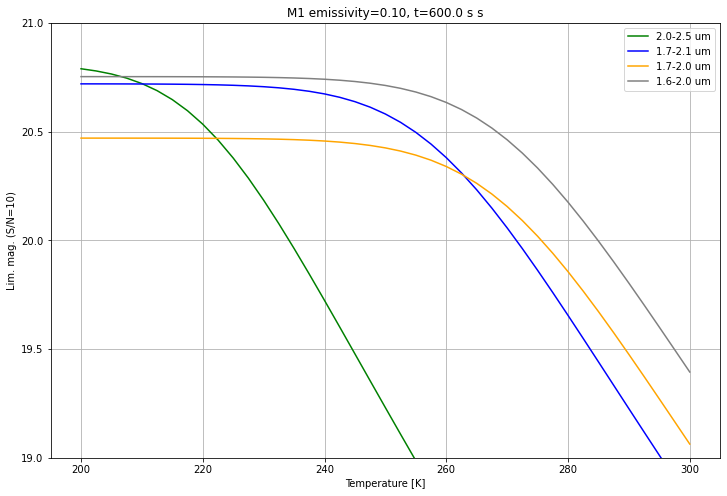

In [62]:
plt.figure(figsize=(12,8))
plt.grid()
#plt.xlim([18, 22])
plt.ylim([19,21])
plt.xlabel('Temperature [K]')
plt.ylabel('Lim. mag. (S/N={})'.format(sn_criterion))
plt.yticks(np.linspace(19, 21, 5))
plt.title('M1 emissivity={:.2f}, t={:.1f} s'.format(emissivity_m1, params.t_exp*n_frames))
plt.plot(tbls['k0']['temperature'], tbls['k0']['mag'], label = '2.0-2.5 um', color='green')
plt.plot(tbls['k1']['temperature'], tbls['k1']['mag'], label = '1.7-2.1 um', color='blue')
plt.plot(tbls['k2']['temperature'], tbls['k2']['mag'], label = '1.7-2.0 um', color='orange')
plt.plot(tbls['k3']['temperature'], tbls['k3']['mag'], label = '1.6-2.0 um', color='gray')
plt.legend()
#plt.plot([17.0, 22.0], [10, 10])
plt.show()

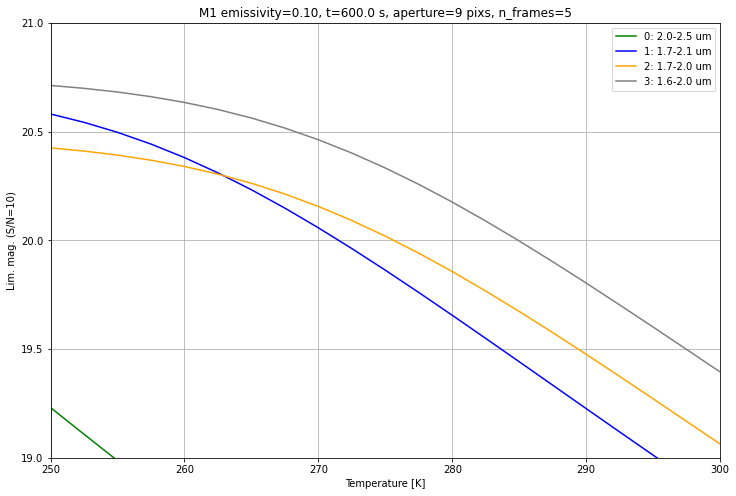

In [63]:
plt.figure(figsize=(12,8))
plt.grid()
plt.xlim([250, 300])
plt.ylim([19,21])
plt.xlabel('Temperature [K]')
plt.ylabel('Lim. mag. (S/N={})'.format(sn_criterion))
plt.yticks(np.linspace(19, 21, 5))
plt.title('M1 emissivity={:.2f}, t={:.1f}, aperture={} pixs, n_frames={}'.format(emissivity_m1, params.t_exp*n_frames, n_pix, n_frames))
plt.plot(tbls['k0']['temperature'], tbls['k0']['mag'], label = '0: 2.0-2.5 um', color='green')
plt.plot(tbls['k1']['temperature'], tbls['k1']['mag'], label = '1: 1.7-2.1 um', color='blue')
plt.plot(tbls['k2']['temperature'], tbls['k2']['mag'], label = '2: 1.7-2.0 um', color='orange')
plt.plot(tbls['k3']['temperature'], tbls['k3']['mag'], label = '3: 1.6-2.0 um', color='gray')
plt.legend()
#plt.plot([17.0, 22.0], [10, 10])
plt.show()

In [64]:
from astropy.table import hstack, join

In [65]:
join(tbls['k0'], tbls['k1'], keys='temperature')

<QTable length=41>
temperature       mag_1              mag_2       
  float64        float64            float64      
----------- ------------------ ------------------
      200.0 20.789209062309947 20.719735818070045
      202.5 20.779016497027868 20.719663482217573
      205.0 20.765023960537967  20.71955492759231
      207.5 20.746129076392002 20.719393647374382
      210.0 20.721079465273835   20.7191563508026
      212.5 20.688545010815012  20.71881048702755
      215.0 20.647237329313132  20.71831099126834
      217.5  20.59606700365451 20.717596061996886
      220.0 20.534309452578082 20.716581757487084
      222.5  20.46173547757707 20.715155195943787
        ...                ...                ...
      277.5 17.964254499798184   19.7600187160372
      280.0 17.859325373910416 19.655166939525454
      282.5 17.756110130931905 19.548777637447206
      285.0 17.654582228621496   19.4414663066983
      287.5 17.554712578844963 19.333742968062996
      290.0 17.456470369424864  19.22602230804147
      292.5 17.359823689810792  19.11863613957523
      295.0  17.26474000677056 19.011846214613378
      297.5 17.171186525296484  18.90585624728098
      300.0  17.07913046145073  18.80082258917447

In [66]:
hstack([tbls['k0']['temperature'], hstack([tbls[key]['mag'] for key in tbls])]).show_in_notebook()

mag1: mag('k0'), mag2: mag('k1'), ...

Save table into an ASCII file.

In [68]:
tbls_stack = hstack([tbls['k0']['temperature'], hstack([tbls[key]['mag'] for key in tbls])])
tbls_stack.write('hgz_t_lmag_e0010.dat', format='ascii')

In [69]:
!ls *.dat

hgz_t_lmag_e0010.dat


In [71]:
!head hgz_t_lmag_e0010.dat

temperature mag_1 mag_2 mag_3 mag_4
200.0 20.789209062309947 20.719735818070045 20.470225003102556 20.752991749871587
202.5 20.779016497027868 20.719663482217573 20.470208784537352 20.752977254360186
205.0 20.765023960537967 20.71955492759231 20.470183934864554 20.75295504002177
207.5 20.746129076392002 20.719393647374382 20.470146258239115 20.75292135152865
210.0 20.721079465273835 20.7191563508026 20.470089709129077 20.752870776281128
212.5 20.688545010815012 20.71881048702755 20.470005660266768 20.752795587474743
215.0 20.647237329313132 20.71831099126834 20.469881914532245 20.752684856764354
217.5 20.59606700365451 20.717596061996886 20.469701383980315 20.752523267044356
220.0 20.534309452578082 20.716581757487084 20.46944034111295 20.752289539198248


# Calculate temperatures achieving required limiting magnitudes.

In [72]:
lim_req = 20.0  # Required limitting magnitude.

In [73]:
from scipy import interpolate

In [85]:
temp_root = [[], []]
for i in range(1,5):
    print(i)
    f = interpolate.interp1d(tbls_stack['temperature'], tbls_stack['mag_{:1d}'.format(i)], kind='cubic')
    def f_solve(x):
        return f(x) - lim_req
    temp_ini = 280.0
    temp_root[0].append(i-1)
    temp_root[1].append(fsolve(f_solve, temp_ini)[0])

1
2
3
4


In [86]:
temp_root

[[0, 1, 2, 3],
 [234.19165640773562, 271.5215694267506, 275.6319419799502, 284.9196816930253]]

In [107]:
print('Lim mag = {}'.format(lim_req))
print('M1_emissivity = {}'.format(emissivity_m1))
print('Case                       Temperature [K]')
for i in range(0, 4):
    print('Case {:} ({:.1f} - {:.1f}): {:.1f}'.format(temp_root[0][i], params.band_wls['k{:1d}'.format(i)][0],
                                                           params.band_wls['k{:1d}'.format(i)][1], temp_root[1][i]))

Lim mag = 20.0
M1_emissivity = 0.1
Case                       Temperature [K]
Case 0 (2.0 um - 2.5 um): 234.2
Case 1 (1.7 um - 2.1 um): 271.5
Case 2 (1.7 um - 2.0 um): 275.6
Case 3 (1.6 um - 2.0 um): 284.9


# Estimation of thermal stray light from the telescope structure.

In [267]:
# Thermal emission of instruments (nominal incident rays from M1).
band = 'k1'
ph_th = (bb_photon_flux_density(temperature,
                               params.band_wls[band][0].value, params.band_wls[band][1].value) *
    emissivity_m1 *
    params.t_exp * n_frames * (params.d_tel/2.0)**2.0*np.pi * params.eff_tel * params.pix_fov * n_pix).decompose().value

In [268]:
ph_th

59327.07135512055

## Calculate thermal stray light from the telescope structure.

$$
p_{structure} = \int \frac{B(\lambda, T)}{hc/\lambda}\ d\lambda \times \Omega_{s} d_{pix}^2 N_{pix} t_{exp} N_{frames}\ \mathrm[photons]
$$

$$
\Omega_{s} = \Omega_{buf} - \Omega_{opt}, \\
\Omega_{opt} \sim \pi \left[\arctan\left(\frac{1}{2F}\right)\right]^2 \sim 0.00784\ \mathrm{sr}\ (\mathrm{for}\  F=10), \\
\Omega_{s}/\Omega_{opt} \sim 6.99\ (\mathrm{for}\ F=10, h_{buffle} = 100\ \mathrm{mm}), \\
\Omega_{s} = \Omega_{opt} \times \left(\Omega_{s}/\Omega_{opt}\right)\sim 0.00784 \times 6.99 \sim 0.548\ \mathrm{sr}
$$

In [269]:
omega_s = 0.548 * u.sr # Solid angle for thermal stray light.
d_pix = 18.0 * u.um  # Pixel size of H1RG array.
# n_pix = 9.0  # Number of pixels of a photometry aperture.
#params.t_exp = 120.0 * u.s  # Exposure time for one exposure.
#n_frames = 5  # Number of frames.
emissivity_structure = 0.3  # Emissivity of the telescope structure.

In [270]:
temperature = 270.0

In [271]:
# Thermal emission from the telescope structure.
ph_st = (bb_photon_flux_density(temperature,
                               params.band_wls[band][0].value, params.band_wls[band][1].value) * \
    emissivity_structure *
    omega_s * d_pix**2 * n_pix *
    params.t_exp * n_frames).decompose().value

In [272]:
ph_st

7547742.379638925

In [273]:
ph_st / ph_th

127.22256816722971

In [274]:
thermal_ratio = {}  # Dict. for thermal emission ratio calculation.

In [275]:
for band in params.bands:
    thermal_ratio[band] = [[], []]
    for temperature in np.linspace(200, 300, 11):
        ph_th = (bb_photon_flux_density(temperature,
                               params.band_wls[band][0].value, params.band_wls[band][1].value) *
                 emissivity_m1 *
                 params.t_exp * n_frames * (params.d_tel/2.0)**2.0*np.pi * params.eff_tel * params.pix_fov * n_pix).decompose().value
        ph_st = (bb_photon_flux_density(temperature,
                               params.band_wls[band][0].value, params.band_wls[band][1].value) *
                 emissivity_structure *
                 omega_s * d_pix**2 * n_pix *
                 params.t_exp * n_frames).decompose().value
        thermal_ratio[band][0].append(temperature)
        thermal_ratio[band][1].append(ph_st/ph_th)


In [276]:
thermal_ratio

{'k0': [[200.0,
   210.0,
   220.0,
   230.0,
   240.0,
   250.0,
   260.0,
   270.0,
   280.0,
   290.0,
   300.0],
  [127.22256816722968,
   127.22256816722974,
   127.22256816722977,
   127.22256816722974,
   127.2225681672298,
   127.22256816722972,
   127.22256816722968,
   127.2225681672297,
   127.22256816722972,
   127.2225681672297,
   127.2225681672297]],
 'k1': [[200.0,
   210.0,
   220.0,
   230.0,
   240.0,
   250.0,
   260.0,
   270.0,
   280.0,
   290.0,
   300.0],
  [127.22256816722971,
   127.22256816722971,
   127.2225681672297,
   127.22256816722972,
   127.22256816722971,
   127.2225681672297,
   127.22256816722968,
   127.22256816722971,
   127.22256816722974,
   127.22256816722971,
   127.22256816722974]],
 'k2': [[200.0,
   210.0,
   220.0,
   230.0,
   240.0,
   250.0,
   260.0,
   270.0,
   280.0,
   290.0,
   300.0],
  [127.22256816722968,
   127.2225681672297,
   127.22256816722971,
   127.2225681672297,
   127.2225681672298,
   127.22256816722971,
   127.222

Independent on temperature and band. Determined only by the geometry and emissivities.

In [277]:
band = 'k1'
emissivity_structure = 0.1
ph_th = (bb_photon_flux_density(temperature,
                               params.band_wls[band][0].value, params.band_wls[band][1].value) * \
    emissivity_m1 * \
    params.t_exp * n_frames * (params.d_tel/2.0)**2.0*np.pi * params.eff_tel * params.pix_fov * n_pix).decompose().value
ph_st = (bb_photon_flux_density(temperature,
                               params.band_wls[band][0].value, params.band_wls[band][1].value) * \
    emissivity_structure *
    omega_s * d_pix**2 * n_pix *
    params.t_exp * n_frames).decompose().value

In [278]:
ph_st / ph_th

42.40752272240991

Photon number ratio between that from the structure and from M1.

$$
\frac{p_{structure}}{p_{M1thermal}} = 42 * \frac{\epsilon_{structure}}{\epsilon_{M1thermal}}, \\
\epsilon_{xxx}: \mathrm{emissivity\ of\ xxx}.
$$